In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from download_PurpleAir_data import *
import datetime
from meteostat import Point, Daily, Hourly, units, Stations
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.ndimage import median_filter
import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Initialize the Nominatim geocoder
geolocator = Nominatim(user_agent="city_latlong_app")

# Get location information for the specified city
city = "Sacramento"
location = geolocator.geocode(f"{city}, California")

# Extract latitude and longitude
if location:
    city_latitude = location.latitude
    city_longitude = location.longitude
    print(f"City: {city}")
    print(f"Latitude: {city_latitude}")
    print(f"Longitude: {city_longitude}")
else:
    print(f"Could not find location for {city}")


City: Sacramento
Latitude: 38.5810606
Longitude: -121.493895


In [29]:
# Function to calculate distance
def is_within_radius(sensor_lat, sensor_lon, center_lat, center_lon, radius):
    if pd.isna(sensor_lat) or pd.isna(sensor_lon):
        return False
    distance = great_circle((center_lat, center_lon), (sensor_lat, sensor_lon)).meters
    return distance <= radius

city_latitude = 38.5816   # Replace with the latitude of the city's center
city_longitude = -121.4944  # Replace with the longitude of the city's center
radius = 1000 # Radius in meters

sensors_df = get_purpleair_sensor_ids()

# Apply the filtering
sensors_df['within_radius'] = sensors_df.apply(
    lambda row: is_within_radius(row['latitude'], row['longitude'], city_latitude, city_longitude, radius),
    axis=1
)

# Filter the DataFrame
filtered_sensors_df = sensors_df[sensors_df['within_radius']]

# Drop the helper column
filtered_sensors_df = filtered_sensors_df.drop(columns=['within_radius'])
filtered_sensors_df.set_index('sensor_index', inplace=True)

indoor_sensors_df = filtered_sensors_df[filtered_sensors_df['location_type'] == 1]
outdoor_sensors_df = filtered_sensors_df[filtered_sensors_df['location_type'] == 0]

display(indoor_sensors_df)
display(outdoor_sensors_df)

,name,location_type,position_rating,latitude,longitude,altitude,confidence
sensor_index,,,,,,,
29839,Upstairs,1,5,38.586113,-121.489120,24.0,30
87865,Whisker flat,1,5,38.586100,-121.486500,24.0,30
100755,New City Hall 5th Floor,1,5,38.582430,-121.493310,23.0,76
100763,Historic City Hall - 3rd FL,1,5,38.581898,-121.493500,24.0,87
117579,Ella,1,5,38.584210,-121.486885,24.0,30


,name,location_type,position_rating,latitude,longitude,altitude,confidence
sensor_index,,,,,,,
19017,The Creamery,0,5,38.587387,-121.490340,25.0,0
38073,SMAQMD,0,5,38.582030,-121.489560,23.0,0
100735,City Hall Complex,0,5,38.582200,-121.493620,23.0,91
111475,Eggplant,0,5,38.584194,-121.486885,24.0,61
173869,Whisker Flat,0,5,38.586130,-121.486565,25.0,100


In [54]:
start_time = datetime.datetime(2024, 6, 1, 0, 0)
end_time = datetime.datetime(2024, 8, 4, 0, 0)
start_stamp = start_time.timestamp() #1652156890
end_stamp = end_time.timestamp() #1675238400
path = f'./Data/{city}'
sensors_data = {}
overwrite = False
sensor_ids = [*indoor_sensors_df.index.values, *outdoor_sensors_df.index.values]
for sensor_id in sensor_ids:
    #check if the file exists
    name = f"{sensor_id}-{start_stamp}-{end_stamp}.parquet"
    if os.path.exists(f"{path}/{name}") == False or overwrite:
        print(f"Fetching data for sensor {sensor_id}")
        fetch_purpleair_data(
            sensor_ids = [sensor_id],
            start_time = start_stamp,
            end_time = end_stamp,
            path = path
        )
    df = pd.read_parquet(f"{path}/{name}")
    df["time"] = df["time_stamp"].map(lambda x: datetime.datetime.fromtimestamp(x))
    df["temperature"] = df["temperature"].map(lambda x: (x - 32) * 5/9) # To Celcius
    df.set_index("time", inplace=True)
    df = df.resample("2min", origin="start").mean().interpolate()
    sensors_data[sensor_id] = df


In [38]:
stations = Stations()
stations = stations.inventory('hourly', start_time)
stations = stations.nearby(city_latitude, city_longitude)
station = stations.fetch(1)
print(station["name"])

# print(station)

meteo_data = Hourly(station, start_time, end_time)

meteo_data = meteo_data.fetch()
meteo_data["wspd"] *= 0.277778 # Convert to m/s


id
72483    Sacramento Executive Airport
Name: name, dtype: object


In [39]:
def kalman_smooth_custom(data, level='local level', ar_order=0, ma_order=0, seasonal=None, cycle=False, plot=False):
    """
    Applies Kalman filter smoothing to a time series using a customizable state-space model.

    Parameters:
    - data (pd.Series): The input time series with a DateTimeIndex.
    - level (str or None): The level component of the model ('local level', 'local linear trend', etc.). Default is 'local linear trend'.
    - seasonal (int or None): The period of the seasonal component (e.g., 12 for monthly data). Default is None.
    - cycle (bool): Whether to include a cyclical component. Default is False.
    - ar_order (int): Order of the AR component in ARMA. Default is 0 (no AR).
    - ma_order (int): Order of the MA component in ARMA. Default is 0 (no MA).
    - plot (bool): Whether to plot the original and smoothed data. Default is True.

    Returns:
    - pd.Series: The smoothed time series.
    """
    # Ensure the data has a DateTimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The data must have a DateTimeIndex.")
    
    # Initialize the UnobservedComponents model
    model = sm.tsa.UnobservedComponents(
        data,
        level=level,
        seasonal=seasonal,
        cycle=cycle,
        ar=ar_order,
        ma=ma_order
    )
    
    # Fit the model
    result = model.fit()
    
    # Extract the smoothed level
    smoothed_data = pd.Series(result.smoothed_state[0], index=data.index)
    
    # Plotting if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(data.index, data, label='Noisy Signal', alpha=0.6)
        plt.plot(smoothed_data.index, smoothed_data, label='Kalman Smoothed', color='red')
        plt.legend()
        plt.title('Kalman Filter Smoothing with Custom States')
        plt.show()
    
    return smoothed_data


In [40]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def fit_exponential_smoothing(data, plot=True):
    model = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=360)
    result = model.fit()

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(data, label='Original Data')
        plt.plot(result.fittedvalues, label='Smoothed Data', color='red')
        plt.legend()
        plt.title('Exponential Smoothing')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.show()

    return result

In [36]:
df["temperature"]

time
2024-06-01 00:01:47    23.333333
2024-06-01 00:03:47    23.333333
2024-06-01 00:05:47    23.333333
2024-06-01 00:07:47    23.333333
2024-06-01 00:09:47          NaN
                         ...    
2024-08-02 15:49:47    43.333333
2024-08-02 15:51:47    43.888889
2024-08-02 15:53:47    43.888889
2024-08-02 15:55:47    43.888889
2024-08-02 15:57:47    43.888889
Freq: 2min, Name: temperature, Length: 45119, dtype: float64

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11828D+00    |proj g|=  1.10418D-01
  ys=-3.270E+00  -gs= 1.025E+00 BFGS update SKIPPED

At iterate    5    f=  1.40203D-01    |proj g|=  1.45398D+00

At iterate   10    f=  9.35918D-02    |proj g|=  4.14457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     32      2     1     0   1.634D-06   9.359D-02
  F =   9.3591654054799217E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


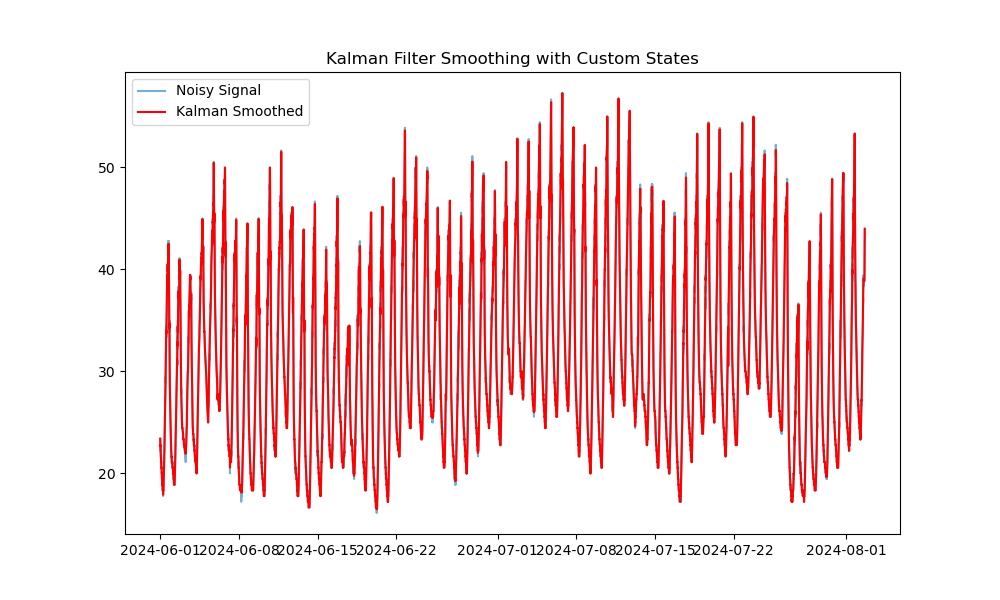

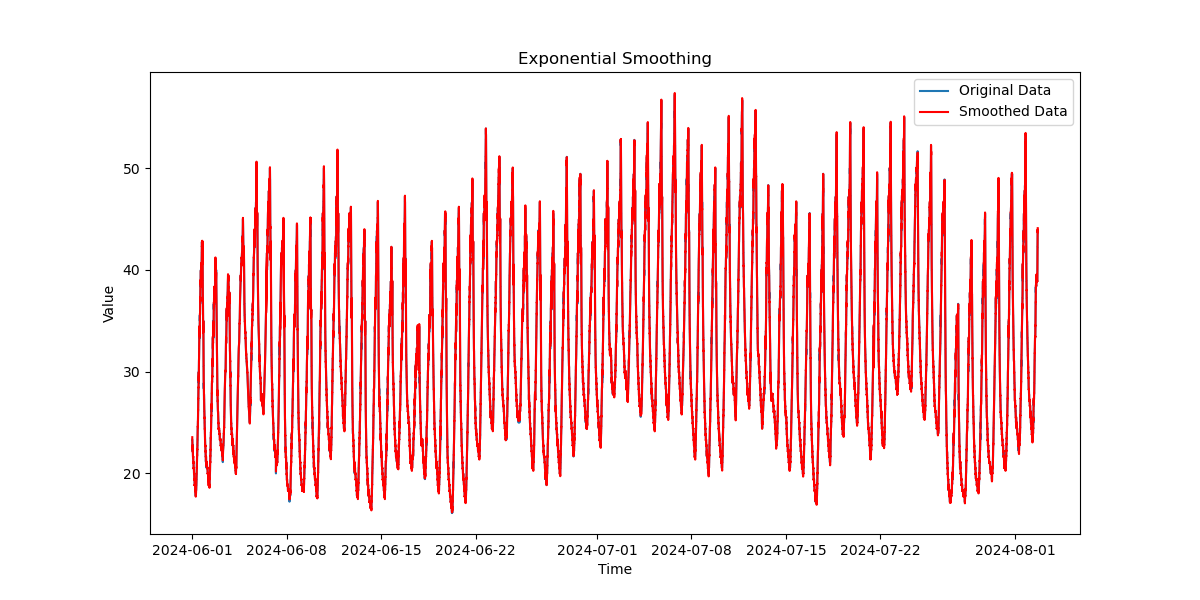

In [41]:
kalman_smooth_custom(df["temperature"], level = 'smooth trend', ar_order = 0, ma_order = 0, plot=True)
fit_exponential_smoothing(df["temperature"], plot=True)

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

def lowess_smooth_ts(s, frac=0.1, plot=True):
    """
    Apply Lowess smoothing to a time series DataFrame.

    Parameters:
    - df: pandas DataFrame with a datetime index.
    - value_col: String, name of the column to smooth.
    - frac: Float, fraction of data used for local fitting (smoothing parameter).
    - plot: Boolean, whether to plot the original and smoothed data.

    Returns:
    - smoothed_df: pandas DataFrame with smoothed values.
    """
    # Ensure the index is a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")
    
    x = s.index
    y = s.values
    
    # Convert datetime index to numeric for lowess
    x_numeric = np.arange(len(x))
    
    # Apply Lowess smoothing
    smoothed = lowess(y, x_numeric, frac=frac)
    
    # Create a DataFrame for the smoothed values
    smoothed_df = pd.DataFrame(data=smoothed, columns=[x.name, 'smoothed'])
    smoothed_df[x.name] = pd.to_datetime(smoothed_df[x.name], unit='D', origin='julian')
    smoothed_df.set_index(x.name, inplace=True)
    
    # Plot results if desired
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, y, label='Original Data', linestyle='dotted', color='gray')
        plt.plot(smoothed_df.index, smoothed_df['smoothed'], label='Lowess Smoothed Data', color='red')
        plt.legend()
        plt.title('Lowess Smoothing')
        plt.xlabel('Time')
        plt.show()

    return smoothed_df

# Apply Lowess smoothing to the temperature data
lowess_smooth_ts(df["temperature"], frac=0.5, plot=True)


OutOfBoundsDatetime: 0            0.0
1            1.0
2            2.0
3            3.0
4            4.0
          ...   
45114    45114.0
45115    45115.0
45116    45116.0
45117    45117.0
45118    45118.0
Name: time, Length: 45119, dtype: float64 is Out of Bounds for origin='julian'

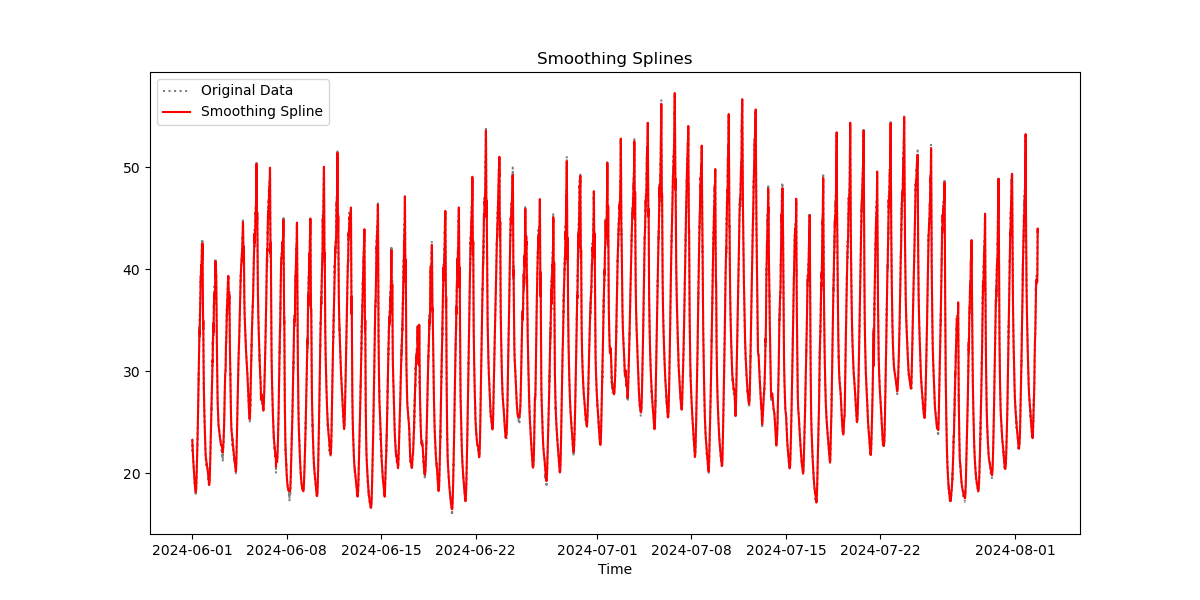

time
2024-06-01 00:01:47    23.254782
2024-06-01 00:03:47    23.212076
2024-06-01 00:05:47    23.169516
2024-06-01 00:07:47    23.127106
2024-06-01 00:09:47    23.084847
                         ...    
2024-08-02 15:49:47    43.887328
2024-08-02 15:51:47    44.000729
2024-08-02 15:53:47    44.010496
2024-08-02 15:55:47    43.899688
2024-08-02 15:57:47    43.651362
Freq: 2min, Length: 45119, dtype: float64

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def smoothing_spline_ts(sr, s=1, plot=True):
    """
    Apply smoothing splines to a time series DataFrame.

    Parameters:
    - df: pandas DataFrame with a datetime index.
    - value_col: String, name of the column to smooth.
    - s: Float, smoothing factor. Larger values result in smoother curves.
    - plot: Boolean, whether to plot the original and smoothed data.

    Returns:
    - spline: UnivariateSpline object for further use.
    - smoothed_df: pandas DataFrame with smoothed values.
    """
    # Ensure the index is a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")
    
    x = sr.index
    y = sr
    
    # Convert datetime index to numeric for smoothing spline
    x_numeric = np.arange(len(x))
    
    # Apply Smoothing Splines
    spline = UnivariateSpline(x_numeric, y, s=s)
    
    # Create a DataFrame for the smoothed values
    smoothed_values = spline(x_numeric)
    smoothed = pd.Series(smoothed_values, index=x)
    
    # Plot results if desired
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(df.index,y, label='Original Data', linestyle='dotted', color='gray')
        plt.plot(smoothed.index, smoothed, label='Smoothing Spline', color='red')
        plt.legend()
        plt.title('Smoothing Splines')
        plt.xlabel('Time')
        plt.show()

    return smoothed

# Example usage
# df = pd.DataFrame({'temperature': np.sin(np.linspace(0, 10, 100)) + np.random.normal(scale=0.5, size=100)}, 
#                    index=pd.date_range(start='2024-01-01', periods=100, freq='D'))
# spline, smoothed_df = smoothing_spline_ts(df, 'temperature', s=1)

# Apply smoothing splines to the temperature data
smoothing_spline_ts(df["temperature"], s=len(df["temperature"])/20, plot=True)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23416D-01    |proj g|=  1.69900D+00

At iterate    5    f= -7.14616D-01    |proj g|=  3.86405D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     36      1     0     0   1.376D-03  -7.146D-01
  F = -0.71462001293759847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59851D+00    |proj g|=  4.89460D-01
  ys=-1.136E+00  -gs= 4.693E-01 BFGS update SKIPPED

At iterate    5    f=  1.93486D-01    |proj g|=  4.86739D+01

At iterate   10    f= -2.67492D-01    |proj g|=  9.83883D+00

At iterate   15    f= -3.67235D-01    |proj g|=  3.10393D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     47      1     1     0   1.364D-05  -3.676D-01
  F = -0.36761275621879608     

CONVERGENCE: REL_

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24074D+00    |proj g|=  6.88389D-01
  ys=-1.606E+00  -gs= 2.941E-01 BFGS update SKIPPED

At iterate    5    f= -4.12021D-01    |proj g|=  1.59133D+01

At iterate   10    f= -4.41053D-01    |proj g|=  2.52419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     34      1     1     0   3.522D-07  -4.411D-01
  F = -0.44105468914108908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06886D+00    |proj g|=  7.90968D-01
  ys=-1.257E+01  -gs= 1.958E-01 BFGS update SKIPPED

At iterate    5    f= -3.59834D-01    |proj g|=  4.91242D+00

At iterate   10    f= -3.73869D-01    |proj g|=  1.70634D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     32      1     1     0   4.919D-05  -3.739D-01
  F = -0.37387600976878005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86783D+00    |proj g|=  3.79201D-01

At iterate    5    f= -4.87877D-01    |proj g|=  7.81010D+00

At iterate   10    f= -5.58647D-01    |proj g|=  5.44453D-01

At iterate   15    f= -5.59633D-01    |proj g|=  3.48109D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     36      1     0     0   3.481D-06  -5.596D-01
  F = -0.55963311262347681     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


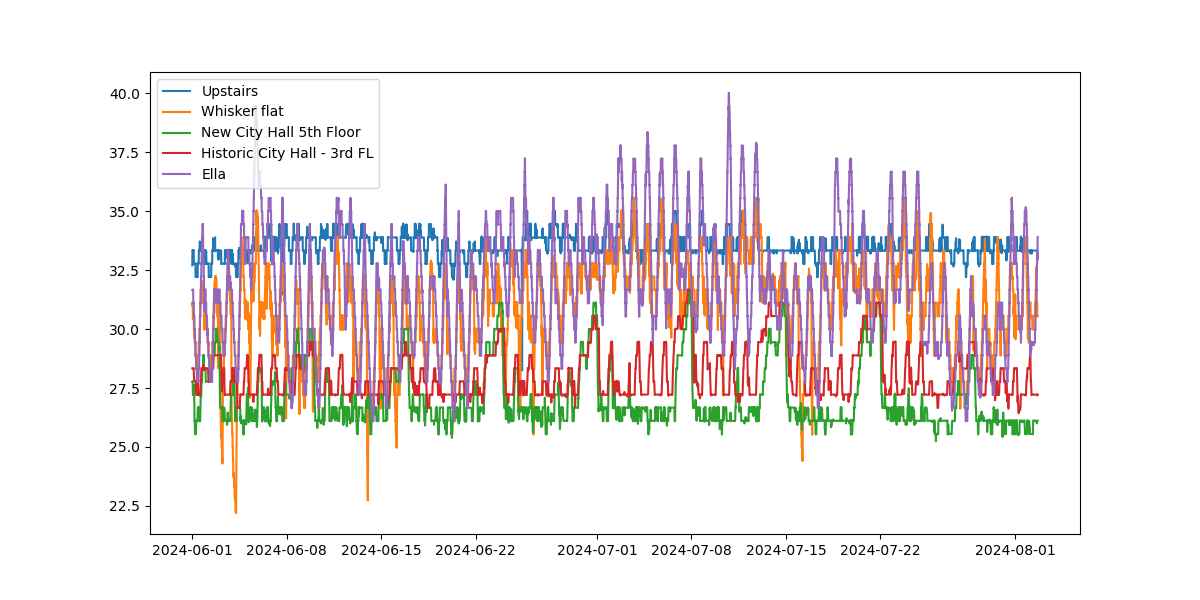

In [22]:
plt.figure(figsize=(12, 6))
for sensor_id in indoor_sensors_df.index:
    df = sensors_data[sensor_id]
    smoothed = kalman_smooth_custom(df["temperature"], level = 'smooth trend')
    name = filtered_sensors_df.loc[sensor_id]['name']
    plt.plot(smoothed, label=name)
# plt.plot(meteo_data.index, meteo_data["temp"], label="Weather Station", linestyle='--')
plt.legend()

In [172]:
stations = Stations()
stations = stations.inventory('hourly', start_time)
stations = stations.nearby(city_latitude, city_longitude)
station = stations.fetch(1)
print(station)

# print(station)

data = Hourly(station, start_time, end_time)

data = data.fetch()
data["wspd"] *= 0.277778 # Convert to m/s

                               name country region    wmo  icao  latitude  \
id                                                                          
72483  Sacramento Executive Airport      US     CA  72483  KSAC      38.5   

       longitude  elevation             timezone hourly_start hourly_end  \
id                                                                         
72483     -121.5        6.0  America/Los_Angeles   1973-01-01 2024-08-15   

      daily_start  daily_end monthly_start monthly_end     distance  
id                                                                   
72483  1941-11-10 2024-12-30    1941-01-01  2022-01-01  9086.568461  


,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-06-01 00:00:00,33.9,9.9,23.0,0.0,NaN,200.0,4.111114,NaN,1007.4,NaN,1.0
2024-06-01 01:00:00,30.6,11.1,30.0,0.0,NaN,200.0,4.611115,NaN,1007.1,NaN,1.0
2024-06-01 02:00:00,30.6,11.1,30.0,0.0,NaN,200.0,4.611115,NaN,1007.1,NaN,1.0
2024-06-01 03:00:00,24.4,9.9,40.0,0.0,NaN,210.0,5.694449,NaN,1007.6,NaN,1.0
2024-06-01 04:00:00,21.1,10.6,51.0,0.0,NaN,210.0,4.611115,NaN,1008.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-03 20:00:00,36.0,9.5,20.0,0.0,NaN,216.0,1.944446,NaN,1012.0,NaN,1.0
2024-08-03 21:00:00,36.7,8.5,18.0,0.0,NaN,250.0,3.111114,NaN,1011.5,NaN,1.0
2024-08-03 22:00:00,37.8,5.9,14.0,0.0,NaN,228.0,2.111113,NaN,1010.9,NaN,1.0


In [166]:
data

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-06-01 00:00:00,33.9,9.9,23.0,0.0,NaN,200.0,14.8,NaN,1007.4,NaN,1.0
2024-06-01 01:00:00,30.6,11.1,30.0,0.0,NaN,200.0,16.6,NaN,1007.1,NaN,1.0
2024-06-01 02:00:00,30.6,11.1,30.0,0.0,NaN,200.0,16.6,NaN,1007.1,NaN,1.0
2024-06-01 03:00:00,24.4,9.9,40.0,0.0,NaN,210.0,20.5,NaN,1007.6,NaN,1.0
2024-06-01 04:00:00,21.1,10.6,51.0,0.0,NaN,210.0,16.6,NaN,1008.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-03 20:00:00,36.0,9.5,20.0,0.0,NaN,216.0,7.0,NaN,1012.0,NaN,1.0
2024-08-03 21:00:00,36.7,8.5,18.0,0.0,NaN,250.0,11.2,NaN,1011.5,NaN,1.0
2024-08-03 22:00:00,37.8,5.9,14.0,0.0,NaN,228.0,7.6,NaN,1010.9,NaN,1.0
